<a href="https://colab.research.google.com/github/manavgurnani21/ECS174_Emotion_Detector/blob/GAN-dev/Final_Project_ADM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Detection with Computer Vision

###Overview
Add Here

# Defining Standard Architecture

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Initialize Data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

/Users/manavgurnani21/ECS174_Emotion_Detector/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:


data_root = os.path.join(path, "images")
train_dir = os.path.join(data_root, "train")
val_dir = os.path.join(data_root, "validation")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5]), transforms.Grayscale(num_output_channels=1)])

train_set = datasets.ImageFolder(root=train_dir, transform=transform)
test_set = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print("Classes:", train_set.classes)
print("Train size:", len(train_set))
print("Test size:", len(test_set))

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train size: 28821
Test size: 7066


In [26]:
def plot_curves(loss, training, test, epochs):
    epochs_axis = range(1, epochs + 1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(epochs_axis, loss, label='Training Loss')
    axes[0].set_title('Training Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs_axis, training, label='Training Accuracy')
    axes[1].set_title('Training Accuracy per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(epochs_axis, test, label='Test Accuracy')
    axes[2].set_title('Test Accuracy per Epoch')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [27]:
def train_model(net, trainloader, testloader, learning_rate = 0.001, criterion = nn.CrossEntropyLoss()):
    epochs = 30
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            if isinstance(criterion, nn.MSELoss):
                targets = F.one_hot(labels, num_classes=10).float()
                loss = criterion(outputs, targets)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        avg_loss = running_loss / len(trainloader)
        train_acc = correct_train / total_train

        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in testloader:
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_acc = correct_test / total_test

        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

    plot_curves(train_losses, train_accs, test_accs, epochs)

# Single Layer Network

In [ ]:
class Single_Layer_Net(nn.Module):
    def __init__(self):
        super(Single_Layer_Net, self).__init__()
        self.fc = nn.Linear(3 * 48 * 48, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 48 * 48)
        x = self.fc(x)
        return x

net = Single_Layer_Net()

In [ ]:
train_model(net, train_loader, test_loader)

KeyboardInterrupt: 

### Findings
Both training and testing accuracy were pretty low when using a single layer network. Training accuracy peaked around 42% while testing accuracy fluctuated between about 24% and 37%.

# ResNet

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, input_channels, output_channels, stride=1):
    super(ResidualBlock, self).__init__()
    # 2 convolutional layers in each residual block
    self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(output_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(output_channels)
    # setting up skip/shortcut layer
    self.shortcut = nn.Sequential()
    if stride != 1 or input_channels != output_channels:
      self.shortcut = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False))

  def forward(self, x):
    # x here is input tensor
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = out + self.shortcut(x)
    out = self.relu(out)
    return out

In [ ]:
class ResNet18(nn.Module):
  def __init__(self, num_classes=10):
    super(ResNet18, self).__init__()
    self.input_channels = 64
    self.conv_1_x = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.conv_2_x = self.make_layer(ResidualBlock, 64, 2, 1)
    self.conv_3_x = self.make_layer(ResidualBlock, 128, 2, 2)
    self.conv_4_x = self.make_layer(ResidualBlock, 256, 2, 2)
    self.conv_5_x = self.make_layer(ResidualBlock, 512, 2, 2)
    self.bn_1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.average_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc_layer = nn.Linear(512, num_classes)

  def make_layer(self, block, output_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.input_channels, output_channels, stride))
      self.input_channels = output_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv_1_x(x)
    out = self.bn_1(out)
    out = self.relu(out)
    # going through residual blocks of convolutional layers
    out = self.conv_2_x(out)
    out = self.conv_3_x(out)
    out = self.conv_4_x(out)
    out = self.conv_5_x(out)
    # average pooling layer for image condensation
    out = self.average_pool(out)¡
    out = out.view(out.size(0), -1)
    # fully connected layer to get ouputs
    out = self.fc_layer(out)
    return out

model = ResNet18(7)

In [ ]:
train_model(model, train_loader, test_loader)

# Data Augmentation

## GAN Implemenation

In [13]:
# Selecting accurate devide to suppose MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# GAN hyperparameters
nz = 100
ngf = 64
ndf = 64
nc = 3
image_size = 48
lr_g = 2e-4
lr_d = 2e-4
beta1 = 0.5
num_gan_epochs = 100

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__() # upsampling images
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__() #downsampling
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),   # 24x24
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 12x12
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 6x6
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 3x3
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),        # 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)



Using Apple Silicon GPU (MPS)


In [14]:
#initialize models
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

criterion_gan = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))


In [15]:
def train_gan(dataloader, num_epochs=num_gan_epochs):
    netG.train()
    netD.train()

    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    for epoch in range(num_epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            b_size = real_imgs.size(0)

            # Real and fake labels
            real_label = torch.ones(b_size, device=device)
            fake_label = torch.zeros(b_size, device=device)


            # 1. Update D: maximize log(D(x)) + log(1 - D(G(z)))
            netD.zero_grad()

            # Real
            output_real = netD(real_imgs)
            lossD_real = criterion_gan(output_real, real_label)

            # Fake
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_imgs = netG(noise).detach()
            output_fake = netD(fake_imgs)
            lossD_fake = criterion_gan(output_fake, fake_label)

            lossD = lossD_real + lossD_fake
            lossD.backward()
            optimizerD.step()


            # 2. Update G: maximize log(D(G(z)))

            netG.zero_grad()
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_imgs = netG(noise)
            output_fake_for_G = netD(fake_imgs)
            lossG = criterion_gan(output_fake_for_G, real_label)
            lossG.backward()
            optimizerG.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")

    #see sample
  #if (epoch + 1) % 10 == 0 or epoch == 0:
    netG.eval()
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    grid = torchvision.utils.make_grid(fake, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated faces")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

train_gan(train_loader, num_epochs=500)  # adjust epochs depending on time


Epoch [1/500]  Loss_D: 0.4008  Loss_G: 4.4216
Epoch [2/500]  Loss_D: 0.3127  Loss_G: 1.8462
Epoch [3/500]  Loss_D: 0.2903  Loss_G: 4.0583
Epoch [4/500]  Loss_D: 0.6385  Loss_G: 5.5068
Epoch [5/500]  Loss_D: 0.5613  Loss_G: 6.5132
Epoch [6/500]  Loss_D: 0.1661  Loss_G: 3.1224
Epoch [7/500]  Loss_D: 0.2889  Loss_G: 4.7869
Epoch [8/500]  Loss_D: 0.2453  Loss_G: 5.0943
Epoch [9/500]  Loss_D: 0.1486  Loss_G: 3.3161
Epoch [10/500]  Loss_D: 0.2895  Loss_G: 6.0842
Epoch [11/500]  Loss_D: 0.3443  Loss_G: 7.4049
Epoch [12/500]  Loss_D: 0.2956  Loss_G: 6.5855
Epoch [13/500]  Loss_D: 0.1264  Loss_G: 6.2783
Epoch [14/500]  Loss_D: 0.6342  Loss_G: 3.5002
Epoch [15/500]  Loss_D: 0.1015  Loss_G: 5.1372
Epoch [16/500]  Loss_D: 0.0539  Loss_G: 5.1107
Epoch [17/500]  Loss_D: 0.0607  Loss_G: 6.4680
Epoch [18/500]  Loss_D: 0.7051  Loss_G: 7.7496
Epoch [19/500]  Loss_D: 0.0645  Loss_G: 5.2369
Epoch [20/500]  Loss_D: 0.0196  Loss_G: 6.2956
Epoch [21/500]  Loss_D: 0.1364  Loss_G: 5.7309
Epoch [22/500]  Loss_D

KeyboardInterrupt: 

## CGAN Implementation

In [20]:
from torch.utils.data import TensorDataset, ConcatDataset

def generate_synthetic_data(generator, num_samples, num_classes=7):
    generator.eval()
    all_imgs = []
    all_labels = []

    with torch.no_grad():
        batch_size = 64
        remaining = num_samples
        while remaining > 0:
            cur_bs = min(batch_size, remaining)
            noise = torch.randn(cur_bs, nz, 1, 1, device=device)
            fake_imgs = generator(noise)
            fake_labels = torch.randint(0, num_classes, (cur_bs,), device=device)

            all_imgs.append(fake_imgs.cpu())
            all_labels.append(fake_labels.cpu())
            remaining -= cur_bs

    all_imgs = torch.cat(all_imgs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return TensorDataset(all_imgs, all_labels)


num_synth = len(train_set)

synthetic_dataset = generate_synthetic_data(netG, num_synth, num_classes=7)


real_imgs = []
real_labels = []
for img, lab in train_set:
    real_imgs.append(img.unsqueeze(0))
    real_labels.append(torch.tensor([lab]))
real_imgs = torch.cat(real_imgs, dim=0)
real_labels = torch.cat(real_labels, dim=0)
real_dataset = TensorDataset(real_imgs, real_labels)

augmented_train_dataset = ConcatDataset([real_dataset, synthetic_dataset])
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=64, shuffle=True)


In [21]:
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models as models
import torch.nn as nn
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 7)
model = resnet18.to(device)

def train_model_with_device(net, trainloader, testloader,
                            learning_rate=0.001,
                            criterion=nn.CrossEntropyLoss()):
    epochs = 50
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            if isinstance(criterion, nn.MSELoss):
                targets = F.one_hot(labels, num_classes=7).float()
                loss = criterion(outputs, targets)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        avg_loss = running_loss / len(trainloader)
        train_acc = correct_train / total_train

        net.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_acc = correct_test / total_test

        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}  Loss: {avg_loss:.4f}  "
              f"Train Acc: {train_acc:.4f}  Test Acc: {test_acc:.4f}")

    plot_curves(train_losses, train_accs, test_accs, epochs)

train_model_with_device(model, augmented_train_loader, test_loader)


Using Apple Silicon GPU (MPS)
Epoch 1/50  Loss: 1.8401  Train Acc: 0.2272  Test Acc: 0.2012
Epoch 2/50  Loss: 1.7386  Train Acc: 0.2790  Test Acc: 0.1901
Epoch 3/50  Loss: 1.6734  Train Acc: 0.3075  Test Acc: 0.2311
Epoch 4/50  Loss: 1.6160  Train Acc: 0.3336  Test Acc: 0.2402
Epoch 5/50  Loss: 1.5505  Train Acc: 0.3592  Test Acc: 0.1912
Epoch 6/50  Loss: 1.4828  Train Acc: 0.3919  Test Acc: 0.2147
Epoch 7/50  Loss: 1.4116  Train Acc: 0.4158  Test Acc: 0.1967
Epoch 8/50  Loss: 1.3484  Train Acc: 0.4420  Test Acc: 0.1772
Epoch 9/50  Loss: 1.2826  Train Acc: 0.4656  Test Acc: 0.2110
Epoch 10/50  Loss: 1.2179  Train Acc: 0.4905  Test Acc: 0.2212
Epoch 11/50  Loss: 1.1773  Train Acc: 0.5051  Test Acc: 0.1954


KeyboardInterrupt: 

Using Apple Silicon GPU (MPS)
Epoch [1/10] LossD=0.0848 LossG=7.5699
Epoch [2/10] LossD=0.0003 LossG=10.9132
Epoch [3/10] LossD=0.0015 LossG=10.3190
Epoch [4/10] LossD=0.0002 LossG=11.8309
Epoch [5/10] LossD=0.0000 LossG=12.4727
Epoch [6/10] LossD=0.0000 LossG=12.4295
Epoch [7/10] LossD=0.0001 LossG=13.0750
Epoch [8/10] LossD=0.0000 LossG=8.1701
Epoch [9/10] LossD=0.0011 LossG=13.5756
Epoch [10/10] LossD=0.0000 LossG=14.7939


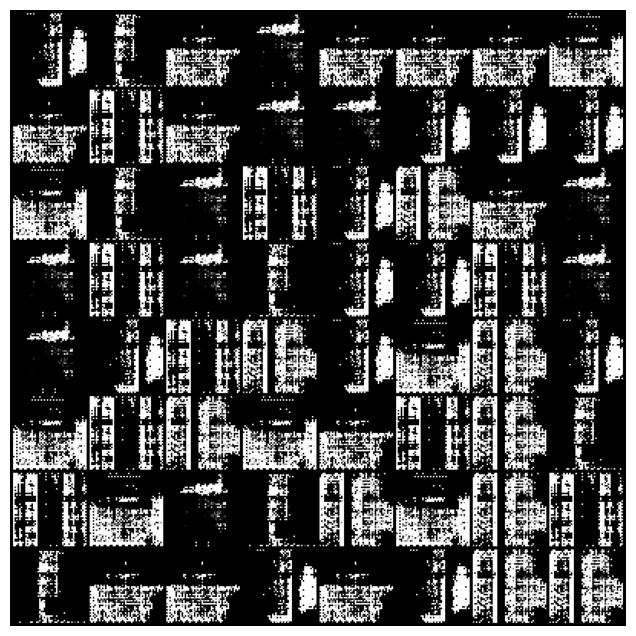

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 1, 48, 48] to have 3 channels, but got 1 channels instead

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# ---------------------
# Hyperparameters
# ---------------------
nz = 100       # noise dimension
ngf = 64       # generator feature maps
ndf = 64       # discriminator feature maps
nc = 1         # image channels
image_size = 48
num_classes = 7
lr_g = 2e-4
lr_d = 2e-4
beta1 = 0.5
num_gan_epochs = 10
batch_size = 64

# ---------------------
# Data transforms
# ---------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*nc, [0.5]*nc)
])

# Assume train_set and test_set are already loaded torchvision datasets
# train_set = ...
# test_set = ...

# Make sure all images are tensors of same size
def make_tensor_dataset(dataset):
    imgs = []
    labels = []
    for img, label in dataset:
        if not isinstance(img, torch.Tensor):
            img = transform(img)
        else:
            # normalize tensor if already tensor
            img = F.interpolate(img.unsqueeze(0), size=(image_size, image_size), mode='bilinear', align_corners=False).squeeze(0)
            img = (img - 0.5)/0.5
        imgs.append(img)
        labels.append(torch.tensor(label))
    imgs = torch.stack(imgs)
    labels = torch.stack(labels)
    return TensorDataset(imgs, labels)

train_dataset = make_tensor_dataset(train_set)
test_dataset = make_tensor_dataset(test_set)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------
# CGAN Models
# ---------------------
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, num_classes):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz+num_classes, ngf*8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([noise, label_embedding], dim=1)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, nc, ndf, num_classes):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.main = nn.Sequential(
            nn.Conv2d(nc+num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        B, C, H, W = img.size()
        label_embedding = self.label_embed(labels).unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.expand(-1, -1, H, W)
        x = torch.cat([img, label_embedding], dim=1)
        return self.main(x).view(-1)

# ---------------------
# Initialize models and optimizers
# ---------------------
netG = Generator(nz, ngf, nc, num_classes).to(device)
netD = Discriminator(nc, ndf, num_classes).to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# ---------------------
# Training CGAN
# ---------------------
def train_cgan(dataloader, num_epochs=num_gan_epochs):
    netG.train()
    netD.train()
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    fixed_labels = torch.randint(0, num_classes, (64,), device=device)

    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            b_size = real_imgs.size(0)

            # Real/Fake labels
            real_label = torch.ones(b_size, device=device)
            fake_label = torch.zeros(b_size, device=device)

            # ------------------
            # Update Discriminator
            # ------------------
            netD.zero_grad()
            # real
            output_real = netD(real_imgs, labels)
            lossD_real = criterion(output_real, real_label)
            # fake
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            random_labels = torch.randint(0, num_classes, (b_size,), device=device)
            fake_imgs = netG(noise, random_labels).detach()
            output_fake = netD(fake_imgs, random_labels)
            lossD_fake = criterion(output_fake, fake_label)

            lossD = lossD_real + lossD_fake
            lossD.backward()
            optimizerD.step()

            # ------------------
            # Update Generator
            # ------------------
            netG.zero_grad()
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            random_labels = torch.randint(0, num_classes, (b_size,), device=device)
            fake_imgs = netG(noise, random_labels)
            output = netD(fake_imgs, random_labels)
            lossG = criterion(output, real_label)
            lossG.backward()
            optimizerG.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] LossD={lossD.item():.4f} LossG={lossG.item():.4f}")

    # Show generated images
    netG.eval()
    with torch.no_grad():
        fake = netG(fixed_noise, fixed_labels).cpu()
    grid = torchvision.utils.make_grid(fake, nrow=8, normalize=True)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.show()

# ---------------------
# Train CGAN
# ---------------------
train_cgan(train_loader)

# ---------------------
# Generate synthetic dataset
# ---------------------
def generate_synthetic_data(generator, num_samples):
    generator.eval()
    all_imgs = []
    all_labels = []
    with torch.no_grad():
        remaining = num_samples
        while remaining > 0:
            cur_bs = min(batch_size, remaining)
            noise = torch.randn(cur_bs, nz, 1, 1, device=device)
            labels = torch.randint(0, num_classes, (cur_bs,), device=device)
            fake_imgs = generator(noise, labels)
            all_imgs.append(fake_imgs.cpu())
            all_labels.append(labels.cpu())
            remaining -= cur_bs
    all_imgs = torch.cat(all_imgs)
    all_labels = torch.cat(all_labels)
    return TensorDataset(all_imgs, all_labels)

synthetic_dataset = generate_synthetic_data(netG, len(train_dataset))
augmented_dataset = ConcatDataset([train_dataset, synthetic_dataset])
augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

# ---------------------
# Train classifier (ResNet18)
# ---------------------
import torchvision.models as models

resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)

def train_classifier(model, trainloader, testloader, lr=0.001, epochs=20):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch {epoch+1}/{epochs}, Loss={total_loss/len(trainloader):.4f}, Acc={correct/total:.4f}")

    # Test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {correct/total:.4f}")

train_classifier(resnet18, augmented_loader, test_loader)
